In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import scipy.optimize
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy.interpolate import pchip_interpolate
import numpy as np
import math
from pandas import Series
from lmfit import Model, Parameter, report_fit
import scipy.ndimage
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from numpy import ones,vstack
from numpy.linalg import lstsq

In [2]:
files = glob.glob('../../../CDOM_DATA/TURB/Turb_cal_4.22.2023/*.txt')
filescdom = '../../../CDOM_DATA/TURB/Turb_2309_4.22.2023/*.txt'

#here is where the output will go 
path2 = '../../../CDOM_DATA/TURB/Turb_cal_4.22.2023.csv'
path3 = '../../../CDOM_DATA/TURB/Turb_CU_2309.csv'
plot1 = "../../../TURB/Color_Curve_abs_456_2309.png"
plot2 = "../../../TURB/Color_Curve_abs_412_2309.png"
spct = '../../../TURB/Spectra_2309.csv'
files

['../../../CDOM_DATA/TURB/Turb_cal_4.22.2023\\ptco_05_Absorbance__0__01.txt',
 '../../../CDOM_DATA/TURB/Turb_cal_4.22.2023\\ptco_100_Absorbance__0__07.txt',
 '../../../CDOM_DATA/TURB/Turb_cal_4.22.2023\\ptco_10_Absorbance__0__02.txt',
 '../../../CDOM_DATA/TURB/Turb_cal_4.22.2023\\ptco_15_Absorbance__0__03.txt',
 '../../../CDOM_DATA/TURB/Turb_cal_4.22.2023\\ptco_20_Absorbance__0__04.txt',
 '../../../CDOM_DATA/TURB/Turb_cal_4.22.2023\\ptco_30_Absorbance__0__00.txt',
 '../../../CDOM_DATA/TURB/Turb_cal_4.22.2023\\ptco_40_Absorbance__0__05.txt',
 '../../../CDOM_DATA/TURB/Turb_cal_4.22.2023\\ptco_50_Absorbance__0__06.txt']

In [3]:
def GET_DATA(name):
    df = pd.read_csv(name, skiprows=15, sep='\t', names=['wl', 'abs'], )
    df['abs'] = df['abs']
    df['wl'] = df['wl']
    #bcorr = df[(df['wl']>=700) & (df['wl']<=701)]['abs'].mean() # a float corection with just 700 nm 
    bcorr = df[(df['wl']>=700) & (df['wl']<=750)]['abs'].mean() # a float corection with 700 to 750 nm 
    df['abs'] = df['abs'] - bcorr
    x = df['wl']
    y = df['abs'] 
    pchip_obj1 = scipy.interpolate.PchipInterpolator(x, y, axis=0, extrapolate=None)
    xi = np.arange(189,881,1)
    yi = pchip_obj1(xi)
    d = {'wl': xi, 'abs': yi}
    df = pd.DataFrame(d)
    return df

In [4]:
frames = []
for f in files:
    df = GET_DATA(f) # runs the processing function 
    ID = f.split("\\")[1] #takes junk out of the file name to make a single ID 
    df = df.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df = df.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df) # adds the new col from each scan to a part of frames 
df = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 
df['wl'] = df.index
df

,ptco_05_Absorbance__0__01.txt,ptco_100_Absorbance__0__07.txt,ptco_10_Absorbance__0__02.txt,ptco_15_Absorbance__0__03.txt,ptco_20_Absorbance__0__04.txt,ptco_30_Absorbance__0__00.txt,ptco_40_Absorbance__0__05.txt,ptco_50_Absorbance__0__06.txt,wl
wl,,,,,,,,,
189,0.899237,0.994056,0.031597,-0.000597,0.075839,-0.133537,0.265135,0.295855,189
190,0.899237,0.994056,0.031597,-0.000597,0.075839,-0.133537,0.265135,0.295855,190
191,0.351940,-0.366752,0.291486,-0.037883,-0.520364,0.159080,1.577588,-0.220020,191
192,-0.847339,0.024745,0.089486,-0.352876,-0.555841,-0.754190,-0.075229,-0.502292,192
193,-0.469470,-0.508795,-0.309771,-0.575795,-0.249215,-0.509369,-0.001765,0.743272,193
...,...,...,...,...,...,...,...,...,...
876,-0.001882,0.001980,-0.001379,-0.006287,-0.000055,0.003985,-0.002108,-0.001051,876
877,0.004053,0.005987,0.004071,0.001022,0.005234,0.009437,0.002892,0.004602,877
878,0.006531,0.008438,0.005084,0.000310,0.001307,0.010348,0.001085,0.004689,878


In [5]:
#HERE WE ARE GOING TO AVERAGE THE SCANNS TO GET A VALUE FOR EACH WAVELENTH
#this filters eveything by all that have the work 'Absorbance' with anything after it 
#and turns it into a new object 
d = df.filter(regex='Absorbance*', axis=1)
#this splits the column names by 
#edit here to make the names a 6 diget number code 
names = d.columns.str.rsplit('_', n=8).str[1]
#this part groups evethign by the sample ID that we have in names then avarages all scanns regardless of how many there are 
df = d.groupby(names, axis=1).mean()
df['wl'] = df.index
df

,05,10,100,15,20,30,40,50,wl
wl,,,,,,,,,
189,0.899237,0.031597,0.994056,-0.000597,0.075839,-0.133537,0.265135,0.295855,189
190,0.899237,0.031597,0.994056,-0.000597,0.075839,-0.133537,0.265135,0.295855,190
191,0.351940,0.291486,-0.366752,-0.037883,-0.520364,0.159080,1.577588,-0.220020,191
192,-0.847339,0.089486,0.024745,-0.352876,-0.555841,-0.754190,-0.075229,-0.502292,192
193,-0.469470,-0.309771,-0.508795,-0.575795,-0.249215,-0.509369,-0.001765,0.743272,193
...,...,...,...,...,...,...,...,...,...
876,-0.001882,-0.001379,0.001980,-0.006287,-0.000055,0.003985,-0.002108,-0.001051,876
877,0.004053,0.004071,0.005987,0.001022,0.005234,0.009437,0.002892,0.004602,877
878,0.006531,0.005084,0.008438,0.000310,0.001307,0.010348,0.001085,0.004689,878


Text(0.5, 1.0, 'color curve 1 CM')

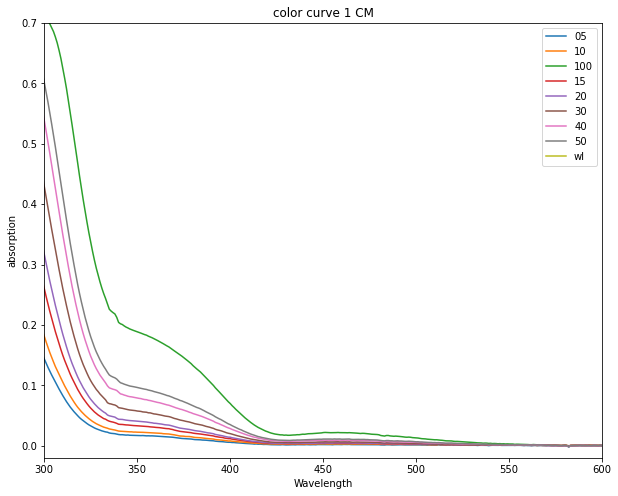

In [6]:
#HERE, WE MAKE A QUICK AND DIRTY GRAPH OF THE DATA TO SAVE AND CHECK WORK 
fig, ax = plt.subplots(figsize=(10,8))
df.plot(label='', ax=ax)
ax.set_ylim(-.02,.7)
ax.set_xlim(300,600)
ax.set_xlabel("Wavelength")
ax.set_ylabel("absorption")
ax.set_title("color curve 1 CM")

#plt.savefig("../../../TURB/PTCO_2309.png")

In [7]:
Frames = []
maxfev = 10000000
for (columnName, columnData) in df.iteritems():
    col = columnName
    
    abs_456 = df[(df['wl']==456)][col].mean()
    abs_412 = df[(df['wl']==412)][col].mean()
    
    dict = {'sample':[columnName],
        'abs_456':[abs_456],
            'abs_412':[abs_412],}
    ss_outs = pd.DataFrame(dict)
    ss_outs = ss_outs.set_index('sample', drop=True)
    Frames.append(ss_outs)

ss_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs = ss_outs.drop('wl')
ss_outs.to_csv(path2)

ss_outs
conc = ss_outs
conc['CU'] = conc.index.astype(int)
conc = conc.sort_values('CU')
conc

,abs_456,abs_412,CU
sample,,,
05,0.001949,0.003072,5
10,0.002760,0.004394,10
15,0.004090,0.006303,15
20,0.004700,0.007421,20
30,0.006366,0.010590,30
40,0.009004,0.014940,40
50,0.011213,0.018391,50
100,0.021726,0.036370,100


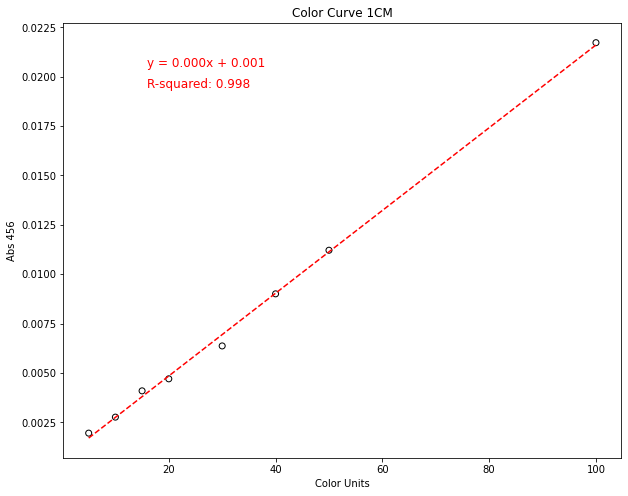

In [8]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(conc['CU'], conc['abs_456'], facecolor='none', edgecolor='black')

# add linear regression line
x = conc['CU']
y = conc['abs_456']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_xlabel('Color Units')
ax.set_ylabel('Abs 456')
ax.set_title('Color Curve 1CM')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')

# show plot
plt.show()


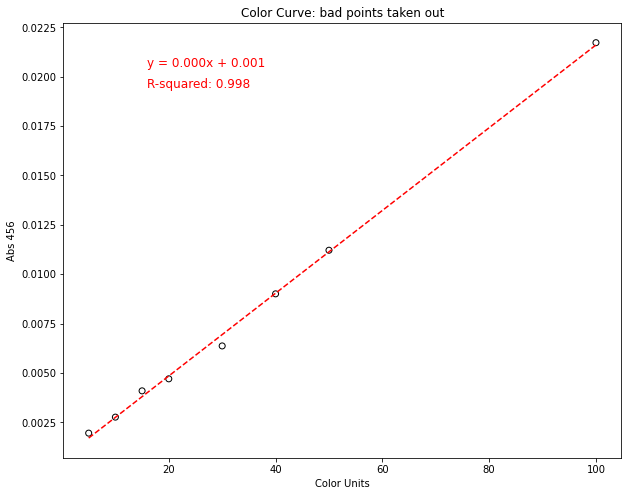

In [9]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))

conc_clean = conc.loc[conc["CU"] != 80]

ax.scatter(conc_clean["CU"], conc_clean['abs_456'], facecolor='none', edgecolor='black')

# add linear regression line
x = conc_clean["CU"]
y = conc_clean['abs_456']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_xlabel('Color Units')
ax.set_ylabel('Abs 456')
ax.set_title('Color Curve: bad points taken out')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')

# show plot
plt.show()

#plt.savefig("../../../TURB/PTCO_abs_456_2309.png")

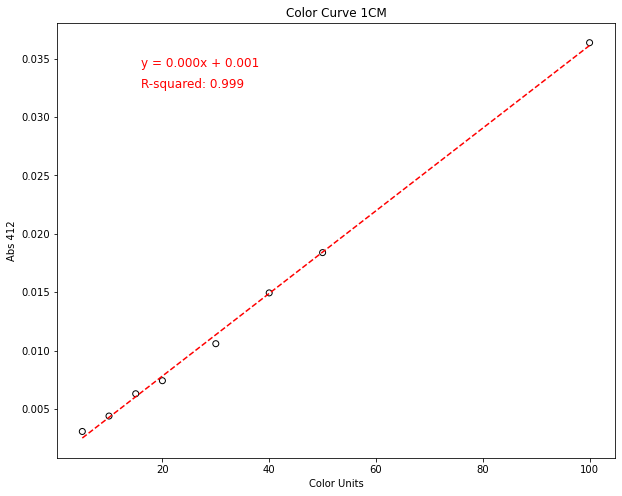

In [10]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(conc['CU'], conc['abs_412'], facecolor='none', edgecolor='black')

# add linear regression line
x = conc['CU']
y = conc['abs_412']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_xlabel('Color Units')
ax.set_ylabel('Abs 412')
ax.set_title('Color Curve 1CM')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')

# show plot
plt.show()


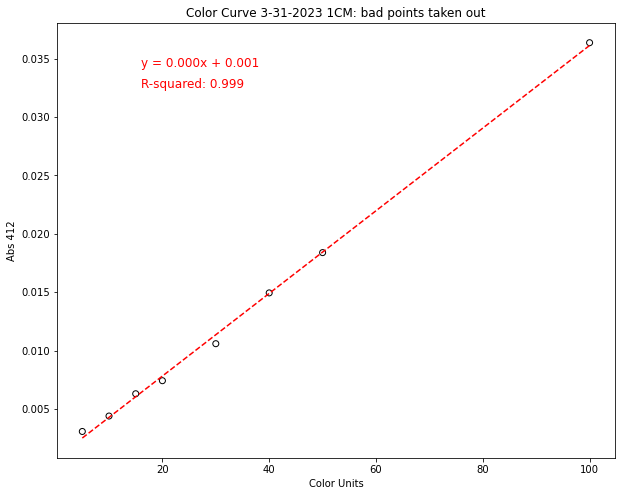

In [11]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(conc_clean['CU'], conc_clean['abs_412'], facecolor='none', edgecolor='black')

# add linear regression line
x = conc_clean['CU']
y = conc_clean['abs_412']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_xlabel('Color Units')
ax.set_ylabel('Abs 412')
ax.set_title('Color Curve 3-31-2023 1CM: bad points taken out')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')

# show plot
plt.show()

#plt.savefig("../../../TURB/PTCO_abs_412_2309.png")

In [12]:
files2 = glob.glob(filescdom)

frames = []
for f in files2:
    df = GET_DATA(f) # runs the processing function 
    ID = f.split("\\")[1] #takes junk out of the file name to make a single ID 
    df = df.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df = df.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df) # adds the new col from each scan to a part of frames 
df = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 
df['wl'] = df.index
df

,230901_Absorbance__0__08.txt,230902_Absorbance__0__09.txt,230903_Absorbance__0__10.txt,230904_Absorbance__0__11.txt,230905_Absorbance__0__12.txt,230906_Absorbance__0__13.txt,230907_Absorbance__0__14.txt,230908_Absorbance__0__15.txt,230909_Absorbance__0__16.txt,230910_Absorbance__0__17.txt,...,230914_Absorbance__0__21.txt,230915_Absorbance__0__22.txt,230915_Absorbance__0__23.txt,230916_Absorbance__0__24.txt,230917_Absorbance__0__25.txt,230918_Absorbance__0__27.txt,230919_Absorbance__0__28.txt,230920_Absorbance__0__29.txt,230921_Absorbance__0__30.txt,wl
wl,,,,,,,,,,,,,,,,,,,,,
189,-0.070427,-0.145589,-0.269101,-0.001240,-0.002372,0.341756,0.097638,0.313672,0.090159,0.009777,...,0.325945,0.036189,-0.029650,0.210696,0.036544,1.351873,1.326206,0.187665,-0.082716,189
190,-0.070427,-0.145589,-0.269101,-0.001240,-0.002372,0.341756,0.097638,0.313672,0.090159,0.009777,...,0.325945,0.036189,-0.029650,0.210696,0.036544,1.351873,1.326206,0.187665,-0.082716,190
191,-0.001227,0.409365,-0.058920,0.287711,0.001904,0.167045,0.122885,0.127907,0.347584,-0.025723,...,-0.015292,-0.033151,-0.108809,0.554184,0.335480,-0.034412,0.425960,-0.166566,-0.032516,191
192,-0.529382,-0.685464,-0.534961,0.678401,-0.584170,-0.386573,-0.747383,-0.564790,-0.683388,-0.745142,...,-0.045883,-0.336168,-0.461770,-0.057933,-0.487081,-0.560480,-0.605383,-0.484560,-0.381797,192
193,-0.530656,-0.482698,-0.414543,-0.518770,0.951507,-0.003544,-0.166633,-0.337070,-0.547929,0.095507,...,-0.376466,-0.244702,0.087751,-0.558378,-0.386023,0.042224,-0.024594,-0.007178,-0.032516,193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,0.000373,-0.002341,0.000149,-0.001840,-0.003445,-0.008779,-0.003944,-0.004848,-0.007686,-0.006364,...,-0.000014,-0.004956,-0.011149,-0.005590,-0.008546,-0.005467,-0.006283,-0.005859,-0.004816,876
877,-0.000184,0.001148,0.002722,0.003525,-0.002420,0.000488,-0.000236,0.004348,0.000435,-0.000160,...,0.000249,-0.000986,0.004397,-0.000460,-0.001761,0.001967,-0.003372,-0.004244,-0.003221,877
878,0.000776,-0.000539,0.004391,0.005844,-0.003571,-0.007225,-0.001454,-0.001348,-0.008405,0.000720,...,-0.002957,-0.000137,-0.000069,-0.000714,-0.005338,-0.000660,-0.000861,-0.002841,-0.000908,878


In [13]:
#HERE WE ARE GOING TO AVERAGE THE SCANNS TO GET A VALUE FOR EACH WAVELENTH
#this filters eveything by all that have the work 'Absorbance' with anything after it 
#and turns it into a new object 
d = df.filter(regex='Absorbance*', axis=1)
#this splits the column names by 
#edit here to make the names a 6 diget number code 
names = d.columns.str.rsplit('_', n=8).str[0]
#this part groups evethign by the sample ID that we have in names then avarages all scanns regardless of how many there are 
df = d.groupby(names, axis=1).mean()
df['wl'] = df.index

dft = df.T
dft.to_csv(spct, index=True)

df

,230901,230902,230903,230904,230905,230906,230907,230908,230909,230910,...,230913,230914,230915,230916,230917,230918,230919,230920,230921,wl
wl,,,,,,,,,,,,,,,,,,,,,
189,-0.070427,-0.145589,-0.269101,-0.001240,-0.002372,0.341756,0.097638,0.313672,0.090159,0.009777,...,0.476372,0.325945,0.003269,0.210696,0.036544,1.351873,1.326206,0.187665,-0.082716,189
190,-0.070427,-0.145589,-0.269101,-0.001240,-0.002372,0.341756,0.097638,0.313672,0.090159,0.009777,...,0.476372,0.325945,0.003269,0.210696,0.036544,1.351873,1.326206,0.187665,-0.082716,190
191,-0.001227,0.409365,-0.058920,0.287711,0.001904,0.167045,0.122885,0.127907,0.347584,-0.025723,...,-0.024728,-0.015292,-0.070980,0.554184,0.335480,-0.034412,0.425960,-0.166566,-0.032516,191
192,-0.529382,-0.685464,-0.534961,0.678401,-0.584170,-0.386573,-0.747383,-0.564790,-0.683388,-0.745142,...,-0.320973,-0.045883,-0.398969,-0.057933,-0.487081,-0.560480,-0.605383,-0.484560,-0.381797,192
193,-0.530656,-0.482698,-0.414543,-0.518770,0.951507,-0.003544,-0.166633,-0.337070,-0.547929,0.095507,...,-0.238004,-0.376466,-0.078476,-0.558378,-0.386023,0.042224,-0.024594,-0.007178,-0.032516,193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,0.000373,-0.002341,0.000149,-0.001840,-0.003445,-0.008779,-0.003944,-0.004848,-0.007686,-0.006364,...,-0.003691,-0.000014,-0.008052,-0.005590,-0.008546,-0.005467,-0.006283,-0.005859,-0.004816,876
877,-0.000184,0.001148,0.002722,0.003525,-0.002420,0.000488,-0.000236,0.004348,0.000435,-0.000160,...,-0.005798,0.000249,0.001706,-0.000460,-0.001761,0.001967,-0.003372,-0.004244,-0.003221,877
878,0.000776,-0.000539,0.004391,0.005844,-0.003571,-0.007225,-0.001454,-0.001348,-0.008405,0.000720,...,-0.003210,-0.002957,-0.000103,-0.000714,-0.005338,-0.000660,-0.000861,-0.002841,-0.000908,878


Text(0.5, 1.0, 'Samples: 1 CM')

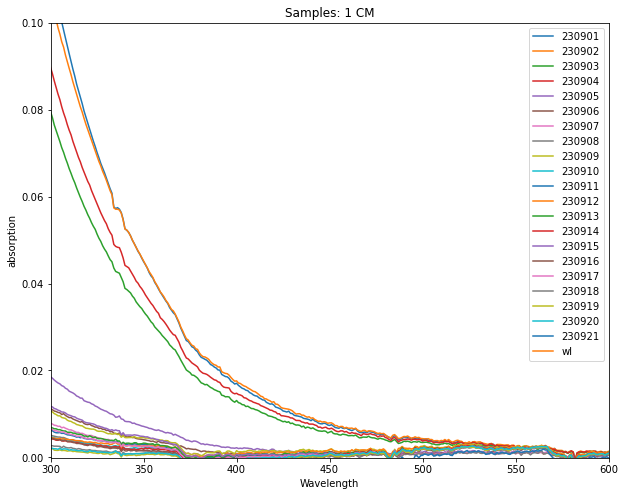

In [14]:
#HERE, WE MAKE A QUICK AND DIRTY GRAPH OF THE DATA TO SAVE AND CHECK WORK 
fig, ax = plt.subplots(figsize=(10,8))
df.plot(label='', ax=ax)
ax.set_ylim(-.0001,.1)
ax.set_xlim(300,600)
ax.set_xlabel("Wavelength")
ax.set_ylabel("absorption")
ax.set_title("Samples: 1 CM")

#plt.savefig("../../../TURB/Spectra_2309.png")

In [15]:
Frames = []
maxfev = 10000000
for (columnName, columnData) in df.iteritems():
    col = columnName
    
    abs_456 = df[(df['wl']==456)][col].mean()
    abs_412 = df[(df['wl']==412)][col].mean()
    
    dict = {'sample':[columnName],
        'abs_456':[abs_456],
            'abs_412':[abs_412],}
    ss_outs = pd.DataFrame(dict)
    ss_outs = ss_outs.set_index('sample', drop=True)
    Frames.append(ss_outs)

ss_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs = ss_outs.drop('wl')

ss_outs.to_csv(path3)

ss_outs

,abs_456,abs_412
sample,,
230901,0.006991,0.013720
230902,0.007123,0.014458
230903,0.005124,0.010699
230904,0.006109,0.012260
230905,0.001128,0.001928
230906,0.000483,0.000888
230907,0.000089,0.000270
230908,0.000103,0.000018
230909,0.001328,0.001459


In [16]:
x = conc_clean['abs_456']
y = conc_clean['CU']
coefficients456 = np.polyfit(x, y, 1)
slope456 = coefficients456[0]
int456 = coefficients456[1]

x = conc_clean['abs_412']
y = conc_clean['CU']
coefficients412 = np.polyfit(x, y, 1)
slope412 = coefficients412[0]
int412 = coefficients412[1]

In [17]:
ss_outs['CU_412'] = (ss_outs['abs_412']*slope412)+int412
ss_outs['CU_456'] = (ss_outs['abs_456']*slope456)+int456

ss_outs.to_csv('../../../TURB/CU_2318.csv', index=True)

ss_outs

,abs_456,abs_412,CU_412,CU_456
sample,,,,
230901,0.006991,0.013720,36.670257,30.247363
230902,0.007123,0.014458,38.752375,30.878525
230903,0.005124,0.010699,28.145887,21.358287
230904,0.006109,0.012260,32.551191,26.050526
230905,0.001128,0.001928,3.401540,2.325973
230906,0.000483,0.000888,0.466916,-0.748861
230907,0.000089,0.000270,-1.277706,-2.624896
230908,0.000103,0.000018,-1.988209,-2.560126
230909,0.001328,0.001459,2.078341,3.277620


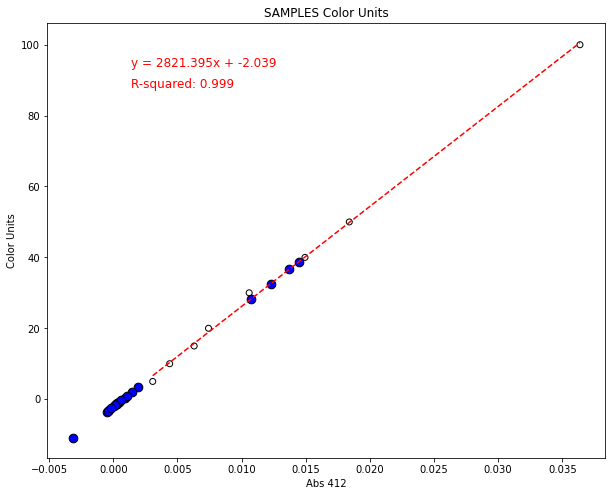

In [18]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(ss_outs['abs_412'], ss_outs['CU_412'], facecolor='blue', edgecolor='black', s = 75)
ax.scatter(conc_clean['abs_412'], conc_clean['CU'], facecolor='none', edgecolor='black')

# add linear regression line
x = conc_clean['abs_412']
y = conc_clean['CU']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_ylabel('Color Units')
ax.set_xlabel('Abs 412')
ax.set_title('SAMPLES Color Units')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')

fig.set_facecolor('w')

plt.savefig(plot2)
# show plot
plt.show()

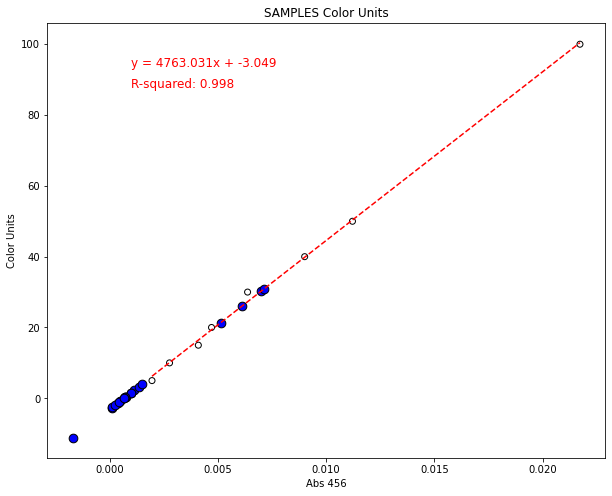

In [19]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(ss_outs['abs_456'], ss_outs['CU_456'], facecolor='blue', edgecolor='black', s = 75)
ax.scatter(conc_clean['abs_456'], conc_clean['CU'], facecolor='none', edgecolor='black')

# add linear regression line
x = conc_clean['abs_456']
y = conc_clean['CU']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_ylabel('Color Units')
ax.set_xlabel('Abs 456')
ax.set_title('SAMPLES Color Units')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')

fig.set_facecolor('w')

plt.savefig(plot1)
# show plot
plt.show()
